# Validation PS-Self/PS-Part


In [1]:
import pandas as pd 
import numpy as np
from tools import *
from sklearn.model_selection import KFold
import random
from collections import Counter
from tqdm import tqdm
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import joblib


random.seed(1016711)
np.random.seed(1016711)


import embedding_metrics.ALBATROSS_idr as albatross
import embedding_metrics.esm2_8m_embedding as esm2_8m

phasepred_related_data_pth = 'data_processed/ps_propensity_prediction_evaluation/phasepred_data/'
phasepred_train_cv_data = pd.read_csv(
    f'{phasepred_related_data_pth}/PhaSePred_train_cv_seqs.csv',sep=',')
independent_test_set_data = pd.read_csv(
    f'{phasepred_related_data_pth}/PhaSePred_test_seqs.csv',sep=','
)

phasepred_train_cv_human_data = pd.read_csv(
    f'{phasepred_related_data_pth}/PhaSePred_train_cv_human_seqs.csv',sep=',')
independent_test_set_human_data = pd.read_csv(
    f'{phasepred_related_data_pth}/PhaSePred_test_human_seqs.csv',sep=','
)
####### precompute feature matrix
# ##########################################

def data2matrix_train_cv_data():
    # precompting for train and cross validation data
    sequences = [
        check_seq_tool(seq) for seq in phasepred_train_cv_data['seq'].values]
    esm_pos_wide_matrix = esm2_8m.get_seq_poswide_embedding_matrix(sequences)
    esm_matrix = []
    for seq,matrix in zip(sequences,esm_pos_wide_matrix):
        assert len(seq) == matrix.shape[0]
        vec_ = np.average(matrix,axis=0)
        esm_matrix.append(vec_)
        assert len(vec_) == 320
    esm_matrix = np.array(esm_matrix)
    np.save(f'{phasepred_related_data_pth}data_matrix/temp_PhaSePred_seqs_esm8m_globalavg_320dim_matrix',esm_matrix)
    alba_matrix_lst = []
    for alba_modelname in ['asphericity','scaled_rg','scaled_re']:
        alba_matrix_lst.append(albatross.get_seqwide_embedding_by_batch(sequences,alba_modelname))
    alba_matrix = np.concatenate(tuple(alba_matrix_lst),axis=1)    
    np.save(f'{phasepred_related_data_pth}/data_matrix/temp_PhaSePred_seqs_albatross_330dim_matrix.npy',alba_matrix)
# data2matrix_train_cv_data()

### precompting for test data
def data2matrix_test_data():
    sequences = [check_seq_tool(seq) for seq in independent_test_set_data['seq'].values]
    esm_pos_wide_matrix = esm2_8m.get_seq_poswide_embedding_matrix(sequences)
    esm_matrix = []
    for seq,matrix in zip(sequences,esm_pos_wide_matrix):
        assert len(seq) == matrix.shape[0]
        vec_ = np.average(matrix,axis=0)
        esm_matrix.append(vec_)
        assert len(vec_) == 320
    esm_matrix = np.array(esm_matrix)
    np.save(f'{phasepred_related_data_pth}/data_matrix/temp_PhaSePred_test_seqs_esm8m_globalavg_320dim_matrix.npy',esm_matrix)
    alba_matrix_lst = []
    for alba_modelname in ['asphericity','scaled_rg','scaled_re']:
        alba_matrix_lst.append(albatross.get_seqwide_embedding_by_batch(sequences,alba_modelname))
    alba_matrix = np.concatenate(tuple(alba_matrix_lst),axis=1)    
    np.save(f'{phasepred_related_data_pth}/temp_PhaSePred_test_seqs_albatross_330dim_matrix.npy',alba_matrix)

# data2matrix_test_data()
## precompting for human train and cross validation data human
def data2matrix_human_train_cv_data():
    sequences = [check_seq_tool(seq) for seq in phasepred_train_cv_human_data['seq'].values]
    esm_pos_wide_matrix = esm2_8m.get_seq_poswide_embedding_matrix(sequences)
    esm_matrix = []
    for seq,matrix in zip(sequences,esm_pos_wide_matrix):
        assert len(seq) == matrix.shape[0]
        vec_ = np.average(matrix,axis=0)
        esm_matrix.append(vec_)
        assert len(vec_) == 320    
    esm_matrix = np.array(esm_matrix)
    np.save(f'{phasepred_related_data_pth}/data_matrix/temp_PhaSePred_human_cv_seqs_esm8m_globalavg_320dim_matrix.npy',esm_matrix)
    alba_matrix_lst = []
    for alba_modelname in ['asphericity','scaled_rg','scaled_re']:
        alba_matrix_lst.append(albatross.get_seqwide_embedding_by_batch(sequences,alba_modelname))
    alba_matrix = np.concatenate(tuple(alba_matrix_lst),axis=1)    
    np.save(f'{phasepred_related_data_pth}/data_matrix/temp_PhaSePred_human_cv_seqs_albatross_330dim_matrix.npy',alba_matrix)
# data2matrix_human_train_cv_data()


### precompting for test data human human
def data2matrix_human_test_data():
    sequences = [check_seq_tool(seq) for seq in independent_test_set_human_data['seq'].values]
    esm_pos_wide_matrix = esm2_8m.get_seq_poswide_embedding_matrix(sequences)
    esm_matrix = []
    for seq,matrix in zip(sequences,esm_pos_wide_matrix):
        assert len(seq) == matrix.shape[0]
        vec_ = np.average(matrix,axis=0)
        esm_matrix.append(vec_)
        assert len(vec_) == 320
    esm_matrix = np.array(esm_matrix)
    np.save(f'{phasepred_related_data_pth}/data_matrix/temp_PhaSePred_human_test_seqs_esm8m_globalavg_320dim_matrix.npy',esm_matrix)
    alba_matrix_lst = []
    for alba_modelname in ['asphericity','scaled_rg','scaled_re']:
        alba_matrix_lst.append(albatross.get_seqwide_embedding_by_batch(sequences,alba_modelname))
    alba_matrix = np.concatenate(tuple(alba_matrix_lst),axis=1)    
    np.save(f'{phasepred_related_data_pth}/data_matrix/temp_PhaSePred_human_test_seqs_albatross_330dim_matrix.npy',alba_matrix)
# data2matrix_human_test_data()

######## loading precomputed matrix
##########################################
train_cv_uids = phasepred_train_cv_data['uniprot_id'].values 
train_cv_category = phasepred_train_cv_data['label'].values 
train_cv_sample_idx = np.array([idx__ for idx__ in range(len(train_cv_category))])
train_cv_labels = np.where(train_cv_category>0,1,0)

test_category = independent_test_set_data['label'].values 
test_sample_idx = np.array([idx__ for idx__ in range(len(test_category))])
test_labels = np.where(test_category>0,1,0)
train_cv_esm_matrix = np.load(
    f'{phasepred_related_data_pth}/data_matrix/temp_PhaSePred_seqs_esm8m_globalavg_320dim_matrix.npy')
train_cv_alba_matrix = np.load(f'{phasepred_related_data_pth}/data_matrix/temp_PhaSePred_seqs_albatross_330dim_matrix.npy')
train_cv_merge_esm_alba_matrix = np.concatenate((train_cv_esm_matrix,train_cv_alba_matrix),axis=1)

train_cv_saps_samples_idx = train_cv_sample_idx[np.where(train_cv_category==1)]
train_cv_pdps_samples_idx = train_cv_sample_idx[np.where(train_cv_category==2)]
train_cv_nops_samples_idx = train_cv_sample_idx[np.where(train_cv_category==0)]

test_esm_matrix = np.load(
    f'{phasepred_related_data_pth}/data_matrix/temp_PhaSePred_test_seqs_esm8m_globalavg_320dim_matrix.npy')
test_alba_matrix = np.load(f'{phasepred_related_data_pth}/data_matrix/temp_PhaSePred_test_seqs_albatross_330dim_matrix.npy')
test_merge_esm_alba_matrix = np.concatenate((test_esm_matrix,test_alba_matrix),
                                            axis=1)
print(test_merge_esm_alba_matrix.shape)

test_saps_samples_idx = test_sample_idx[np.where(test_category==1)]
test_pdps_samples_idx = test_sample_idx[np.where(test_category==2)]
test_nops_samples_idx = test_sample_idx[np.where(test_category==0)]


loading or downloading model
(12235, 650)


In [ ]:

# #########################################
# ################# five fold cross validation/validation
train_cv_positive_dataset_idx = train_cv_pdps_samples_idx
print(len(train_cv_positive_dataset_idx))
vali_positive_dataset_idx = test_pdps_samples_idx
print(len(vali_positive_dataset_idx))

train_cv_data_matrix = train_cv_merge_esm_alba_matrix
vali_data_matrix = test_merge_esm_alba_matrix

fold = 5
cv_auc_lst,cv_aupr_lst = [],[]
val_auc_lst,val_aupr_lst = [],[]
iter = 10
def model():
    m = LogisticRegression(class_weight='balanced',penalty='l1',
                               solver='liblinear',max_iter=100)
    # m = RandomForestClassifier(class_weight='balanced',max_depth=15)
    return m
training_uids = []
for j in tqdm(range(iter)): 
    train_cv_nops_sample_subset_idx = np.random.choice(
        train_cv_nops_samples_idx,len(train_cv_positive_dataset_idx)*3,replace=False)
    train_cv_merge_pos_neg_sample_idx_list = np.array(
        list(train_cv_positive_dataset_idx)+list(train_cv_nops_sample_subset_idx))
    
    np.random.shuffle(train_cv_merge_pos_neg_sample_idx_list)
    train_cv_idx_lst = train_cv_merge_pos_neg_sample_idx_list.copy()
    cv_avg_auc,cv_avg_aupr = 0,0
    kf = KFold(n_splits=fold,shuffle=True)
    train_data = train_cv_data_matrix.copy()
    for _,(train_i,val_i) in enumerate(kf.split(train_cv_idx_lst)):  
        train_idx,val_idx = train_cv_idx_lst[train_i],train_cv_idx_lst[val_i]
        train_x = train_cv_data_matrix[train_idx]
        train_y = train_cv_labels[train_idx]
        test_x = train_cv_data_matrix[val_idx]
        test_y = train_cv_labels[val_idx]
        m = model()
        m.fit(train_x,train_y)
        py = m.predict_proba(test_x)[:,1]
        bauc,baupr = balanced_auc_aupr(test_y,py)
        cv_avg_auc += bauc
        cv_avg_aupr += baupr 
        del m,bauc,baupr
    cv_avg_auc /= fold 
    cv_avg_aupr /= fold
    cv_auc_lst.append(cv_avg_auc)
    cv_aupr_lst.append(cv_avg_aupr)
    x = train_data[train_cv_merge_pos_neg_sample_idx_list]
    y = train_cv_labels[train_cv_merge_pos_neg_sample_idx_list]
    vali_nops_sample_subset_idx = np.random.choice(
        test_nops_samples_idx,len(vali_positive_dataset_idx)*2,
                                              replace=False)
    vali_merge_pos_neg_sample_idx_list = np.array(
        list(vali_positive_dataset_idx)+list(vali_nops_sample_subset_idx))
    
    np.random.shuffle(vali_merge_pos_neg_sample_idx_list)
    vali_x = vali_data_matrix[vali_merge_pos_neg_sample_idx_list]
    vali_y = test_labels[vali_merge_pos_neg_sample_idx_list]
    uids = train_cv_uids[train_cv_merge_pos_neg_sample_idx_list]
    training_uids += list(uids)
    test_m = model()
    test_m.fit(x,y)
    py = test_m.predict_proba(vali_x)[:,1]
    
    bauc,baupr = balanced_auc_aupr(vali_y,py)
    val_auc_lst.append(bauc)
    val_aupr_lst.append(baupr)
    

print('cross validation auc median/average/max/min',np.median(cv_auc_lst),np.average(cv_auc_lst),
      np.max(cv_auc_lst),np.min(cv_auc_lst))
print('cross validation aupr median/max/min',
      np.median(cv_aupr_lst),np.max(cv_aupr_lst),np.min(cv_aupr_lst))
 
print('test auc median/average/max/min',np.median(val_auc_lst),np.average(val_auc_lst),
      np.max(val_auc_lst),np.min(val_auc_lst))
print('test aupr median/max/min',
      np.median(val_aupr_lst),np.max(val_aupr_lst),np.min(val_aupr_lst))


214
112


100%|██████████| 10/10 [00:18<00:00,  1.88s/it]

cross validation auc median/average/max/min 0.8010032076978993 0.7993338362851672 0.8224144486959164 0.7696163272933104
cross validation aupr median/max/min 0.766792830913813 0.7971592928471047 0.728082287776644
test auc median/average/max/min 0.7587040777679586 0.7582815301098346 0.7820906451205655 0.7279876278247696
test aupr median/max/min 0.7397548923298797 0.763384274359915 0.6852765799480622


In [3]:
# #########################################
# ################# five fold cross validation/validation PS-Self
train_cv_positive_dataset_idx = train_cv_saps_samples_idx
print(len(train_cv_positive_dataset_idx))
vali_positive_dataset_idx = test_saps_samples_idx
print(len(vali_positive_dataset_idx))

train_cv_data_matrix = train_cv_merge_esm_alba_matrix
vali_data_matrix = test_merge_esm_alba_matrix
fold = 5
cv_auc_lst,cv_aupr_lst = [],[]
val_auc_lst,val_aupr_lst = [],[]
iter = 10
def model():
    m = LogisticRegression(class_weight='balanced',penalty='l1',
                               solver='liblinear',max_iter=100)
    # m = RandomForestClassifier(class_weight='balanced',max_depth=15)
    return m
training_uids = []
for j in tqdm(range(iter)): 
    train_cv_nops_sample_subset_idx = np.random.choice(
        train_cv_nops_samples_idx,len(train_cv_positive_dataset_idx)*3,replace=False)
    train_cv_merge_pos_neg_sample_idx_list = np.array(
        list(train_cv_positive_dataset_idx)+list(train_cv_nops_sample_subset_idx))
    
    np.random.shuffle(train_cv_merge_pos_neg_sample_idx_list)
    train_cv_idx_lst = train_cv_merge_pos_neg_sample_idx_list.copy()
    cv_avg_auc,cv_avg_aupr = 0,0
    kf = KFold(n_splits=fold,shuffle=True)
    train_data = train_cv_data_matrix.copy()
    for _,(train_i,val_i) in enumerate(kf.split(train_cv_idx_lst)):  
        train_idx,val_idx = train_cv_idx_lst[train_i],train_cv_idx_lst[val_i]
        train_x = train_cv_data_matrix[train_idx]
        train_y = train_cv_labels[train_idx]
        test_x = train_cv_data_matrix[val_idx]
        test_y = train_cv_labels[val_idx]
        m = model()
        m.fit(train_x,train_y)
        py = m.predict_proba(test_x)[:,1]
        bauc,baupr = balanced_auc_aupr(test_y,py)
        cv_avg_auc += bauc
        cv_avg_aupr += baupr 
        del m,bauc,baupr
    cv_avg_auc /= fold 
    cv_avg_aupr /= fold
    cv_auc_lst.append(cv_avg_auc)
    cv_aupr_lst.append(cv_avg_aupr)
    x = train_data[train_cv_merge_pos_neg_sample_idx_list]
    y = train_cv_labels[train_cv_merge_pos_neg_sample_idx_list]
    vali_nops_sample_subset_idx = np.random.choice(
        test_nops_samples_idx,len(vali_positive_dataset_idx)*2,
                                              replace=False)
    vali_merge_pos_neg_sample_idx_list = np.array(
        list(vali_positive_dataset_idx)+list(vali_nops_sample_subset_idx))
    
    np.random.shuffle(vali_merge_pos_neg_sample_idx_list)
    vali_x = vali_data_matrix[vali_merge_pos_neg_sample_idx_list]
    vali_y = test_labels[vali_merge_pos_neg_sample_idx_list]
    uids = train_cv_uids[train_cv_merge_pos_neg_sample_idx_list]
    training_uids += list(uids)
    test_m = model()
    test_m.fit(x,y)
    py = test_m.predict_proba(vali_x)[:,1]
    
    bauc,baupr = balanced_auc_aupr(vali_y,py)
    val_auc_lst.append(bauc)
    val_aupr_lst.append(baupr)
    

print('cross validation auc median/average/max/min',np.median(cv_auc_lst),np.average(cv_auc_lst),
      np.max(cv_auc_lst),np.min(cv_auc_lst))
print('cross validation aupr median/max/min',
      np.median(cv_aupr_lst),np.max(cv_aupr_lst),np.min(cv_aupr_lst))
 
print('test auc median/average/max/min',np.median(val_auc_lst),np.average(val_auc_lst),
      np.max(val_auc_lst),np.min(val_auc_lst))
print('test aupr median/max/min',
      np.median(val_aupr_lst),np.max(val_aupr_lst),np.min(val_aupr_lst))

128
73


100%|██████████| 10/10 [00:10<00:00,  1.06s/it]

cross validation auc median/average/max/min 0.8864311254290977 0.8873702913958998 0.9008170967970524 0.8760516159326082
cross validation aupr median/max/min 0.8932276065211118 0.9089924905192049 0.8794831128065969
test auc median/average/max/min 0.8447800237812126 0.8479565992865636 0.868923900118906 0.8182609988109389
test aupr median/max/min 0.8624476644235778 0.8829232030013098 0.8158891002698931


In [4]:
#################### PhaSePred HUMAN dataset
train_cv_category = phasepred_train_cv_human_data['label'].values
train_cv_uids = phasepred_train_cv_human_data['uniprot_id'].values 
train_cv_sample_idx = np.array([idx__ for idx__ in range(len(train_cv_category))])
train_cv_labels = np.where(train_cv_category>0,1,0)

test_category = independent_test_set_human_data['label'].values 
test_sample_idx = np.array([idx__ for idx__ in range(len(test_category))])
test_labels = np.where(test_category>0,1,0)

train_cv_esm_matrix = np.load(f'{phasepred_related_data_pth}/data_matrix/temp_PhaSePred_human_cv_seqs_esm8m_globalavg_320dim_matrix.npy')
train_cv_alba_matrix = np.load(
    f'{phasepred_related_data_pth}/data_matrix/temp_PhaSePred_human_cv_seqs_albatross_330dim_matrix.npy')
train_cv_merge_esm_alba_matrix = np.concatenate((train_cv_esm_matrix,train_cv_alba_matrix),axis=1)
print(train_cv_esm_matrix.shape)


train_cv_saps_samples_idx = train_cv_sample_idx[np.where(train_cv_category==1)]
train_cv_pdps_samples_idx = train_cv_sample_idx[np.where(train_cv_category==2)]
train_cv_nops_samples_idx = train_cv_sample_idx[np.where(train_cv_category==0)]
print(len(train_cv_saps_samples_idx))
test_esm_matrix = np.load(f'{phasepred_related_data_pth}/data_matrix/temp_PhaSePred_human_test_seqs_esm8m_globalavg_320dim_matrix.npy')
test_alba_matrix = np.load(
    f'{phasepred_related_data_pth}/data_matrix/temp_PhaSePred_human_test_seqs_albatross_330dim_matrix.npy')
test_merge_esm_alba_matrix = np.concatenate((test_esm_matrix,test_alba_matrix),
                                            axis=1)

print(test_merge_esm_alba_matrix.shape)

test_saps_samples_idx = test_sample_idx[np.where(test_category==1)]
test_pdps_samples_idx = test_sample_idx[np.where(test_category==2)]
test_nops_samples_idx = test_sample_idx[np.where(test_category==0)]
test_ps_samples_idx = test_sample_idx[np.where(test_category==3)]


(8956, 320)
59
(2317, 650)


In [5]:
########################################
################ five fold cross validation/validation PS-SELF/PS-PART
train_cv_positive_dataset_idx = train_cv_pdps_samples_idx
vali_positive_dataset_idx = test_pdps_samples_idx
test_positive_dataset_idx = test_ps_samples_idx

train_cv_data_matrix = train_cv_merge_esm_alba_matrix
vali_data_matrix = test_merge_esm_alba_matrix
test_data_matrix = test_merge_esm_alba_matrix



fold = 5
cv_auc_lst,cv_aupr_lst = [],[]
val_auc_lst,val_aupr_lst = [],[]
test_auc_lst,test_aupr_lst = [],[]
iter = 50
np.random.seed(1016)
training_uids = []
for j in tqdm(range(iter)): 
    train_cv_nops_sample_subset_idx = np.random.choice(
        train_cv_nops_samples_idx,len(train_cv_positive_dataset_idx)*3,replace=False)
    train_cv_merge_pos_neg_sample_idx_list = np.array(
        list(train_cv_positive_dataset_idx)+list(train_cv_nops_sample_subset_idx))
    
    np.random.shuffle(train_cv_merge_pos_neg_sample_idx_list)
    train_cv_idx_lst = train_cv_merge_pos_neg_sample_idx_list.copy()
    cv_avg_auc,cv_avg_aupr = 0,0
    kf = KFold(n_splits=fold,shuffle=True)
    train_data = train_cv_data_matrix.copy()
    for _,(train_i,val_i) in enumerate(kf.split(train_cv_idx_lst)):  
        train_idx,val_idx = train_cv_idx_lst[train_i],train_cv_idx_lst[val_i]
        train_x = train_cv_data_matrix[train_idx]
        train_y = train_cv_labels[train_idx]
        test_x = train_cv_data_matrix[val_idx]
        test_y = train_cv_labels[val_idx]
        m = LogisticRegression(class_weight='balanced',penalty='l1',solver='liblinear',max_iter=300)
        m.fit(train_x,train_y)
        py = m.predict_proba(test_x)[:,1]
        bauc,baupr = roc_auc_score(test_y,py),compute_aupr(test_y,py)
        cv_avg_auc += bauc
        cv_avg_aupr += baupr 
        del m,bauc,baupr
    cv_avg_auc /= fold 
    cv_avg_aupr /= fold
    cv_auc_lst.append(cv_avg_auc)
    cv_aupr_lst.append(cv_avg_aupr)
    x = train_data[train_cv_merge_pos_neg_sample_idx_list]
    y = train_cv_labels[train_cv_merge_pos_neg_sample_idx_list]
    uids = train_cv_uids[train_cv_merge_pos_neg_sample_idx_list]
    training_uids += list(uids)
    vali_nops_sample_subset_idx = np.random.choice(
        test_nops_samples_idx,len(vali_positive_dataset_idx)*2,
                                              replace=False)
    vali_merge_pos_neg_sample_idx_list = np.array(
        list(vali_positive_dataset_idx)+list(vali_nops_sample_subset_idx))
    
    np.random.shuffle(vali_merge_pos_neg_sample_idx_list)
    vali_x = vali_data_matrix[vali_merge_pos_neg_sample_idx_list]
    vali_y = test_labels[vali_merge_pos_neg_sample_idx_list]
    test_m = LogisticRegression(class_weight='balanced',penalty='l1',solver='liblinear',max_iter=300)
    # test_m = RandomForestClassifier(max_depth=5,class_weight='balanced')
    test_m.fit(x,y)
    py = test_m.predict_proba(vali_x)[:,1]
    # py = test_m.predict(vali_x)
    bauc,baupr = roc_auc_score(vali_y,py),compute_aupr(vali_y,py)
    val_auc_lst.append(bauc)
    val_aupr_lst.append(baupr)
    ############ test set (small data set)
    test_nops_sample_subset_idx = np.random.choice(
        test_nops_samples_idx,len(test_positive_dataset_idx)*2,
                                              replace=False)
    test_merge_pos_neg_sample_idx_list = np.array(
        list(test_positive_dataset_idx)+list(test_nops_sample_subset_idx))
    
    np.random.shuffle(test_merge_pos_neg_sample_idx_list)
    itest_x = vali_data_matrix[test_merge_pos_neg_sample_idx_list]
    itest_y = test_labels[test_merge_pos_neg_sample_idx_list]
    py = test_m.predict_proba(itest_x)[:,1]
    bauc,baupr = roc_auc_score(itest_y,py),compute_aupr(itest_y,py)
    test_auc_lst.append(bauc)
    test_aupr_lst.append(baupr)

print('independent vali auc median/average/max/min',np.median(val_auc_lst),np.average(val_auc_lst),
      np.max(val_auc_lst),np.min(val_auc_lst))
print('independent vali aupr median/max/min',
      np.median(val_aupr_lst),np.max(val_aupr_lst),np.min(val_aupr_lst))

print('small test vali auc median/average/max/min',np.median(test_auc_lst),np.average(test_auc_lst),
      np.max(test_auc_lst),np.min(test_auc_lst))
print('small test vali aupr median/max/min',
      np.median(test_aupr_lst),np.max(test_aupr_lst),np.min(test_aupr_lst))


100%|██████████| 50/50 [00:06<00:00,  7.23it/s]

independent vali auc median/average/max/min 0.8120138888888888 0.8135805555555555 0.85875 0.7459722222222223
independent vali aupr median/max/min 0.6598870669176194 0.7430899327935803 0.568516320328796
small test vali auc median/average/max/min 0.8525519848771266 0.8454631379962193 0.9007561436672968 0.7665406427221172
small test vali aupr median/max/min 0.7512116801501827 0.8326016907587254 0.5317039783208791


In [6]:
################ five fold cross validation/validation PS-SELF
train_cv_positive_dataset_idx = train_cv_saps_samples_idx
vali_positive_dataset_idx = test_saps_samples_idx
test_positive_dataset_idx = test_ps_samples_idx

train_cv_data_matrix = train_cv_merge_esm_alba_matrix
vali_data_matrix = test_merge_esm_alba_matrix
test_data_matrix = test_merge_esm_alba_matrix



fold = 5
cv_auc_lst,cv_aupr_lst = [],[]
val_auc_lst,val_aupr_lst = [],[]
test_auc_lst,test_aupr_lst = [],[]
iter = 50
np.random.seed(1016)
training_uids = []
for j in tqdm(range(iter)): 
    train_cv_nops_sample_subset_idx = np.random.choice(
        train_cv_nops_samples_idx,len(train_cv_positive_dataset_idx)*3,replace=False)
    train_cv_merge_pos_neg_sample_idx_list = np.array(
        list(train_cv_positive_dataset_idx)+list(train_cv_nops_sample_subset_idx))
    
    np.random.shuffle(train_cv_merge_pos_neg_sample_idx_list)
    train_cv_idx_lst = train_cv_merge_pos_neg_sample_idx_list.copy()
    cv_avg_auc,cv_avg_aupr = 0,0
    kf = KFold(n_splits=fold,shuffle=True)
    train_data = train_cv_data_matrix.copy()
    for _,(train_i,val_i) in enumerate(kf.split(train_cv_idx_lst)):  
        train_idx,val_idx = train_cv_idx_lst[train_i],train_cv_idx_lst[val_i]
        train_x = train_cv_data_matrix[train_idx]
        train_y = train_cv_labels[train_idx]
        test_x = train_cv_data_matrix[val_idx]
        test_y = train_cv_labels[val_idx]
        m = LogisticRegression(class_weight='balanced',penalty='l1',solver='liblinear',max_iter=300)
        m.fit(train_x,train_y)
        py = m.predict_proba(test_x)[:,1]
        bauc,baupr = roc_auc_score(test_y,py),compute_aupr(test_y,py)
        cv_avg_auc += bauc
        cv_avg_aupr += baupr 
        del m,bauc,baupr
    cv_avg_auc /= fold 
    cv_avg_aupr /= fold
    cv_auc_lst.append(cv_avg_auc)
    cv_aupr_lst.append(cv_avg_aupr)
    x = train_data[train_cv_merge_pos_neg_sample_idx_list]
    y = train_cv_labels[train_cv_merge_pos_neg_sample_idx_list]
    uids = train_cv_uids[train_cv_merge_pos_neg_sample_idx_list]
    training_uids += list(uids)
    vali_nops_sample_subset_idx = np.random.choice(
        test_nops_samples_idx,len(vali_positive_dataset_idx)*2,
                                              replace=False)
    vali_merge_pos_neg_sample_idx_list = np.array(
        list(vali_positive_dataset_idx)+list(vali_nops_sample_subset_idx))
    
    np.random.shuffle(vali_merge_pos_neg_sample_idx_list)
    vali_x = vali_data_matrix[vali_merge_pos_neg_sample_idx_list]
    vali_y = test_labels[vali_merge_pos_neg_sample_idx_list]
    test_m = LogisticRegression(class_weight='balanced',penalty='l1',solver='liblinear',max_iter=300)
    # test_m = RandomForestClassifier(max_depth=5,class_weight='balanced')
    test_m.fit(x,y)
    py = test_m.predict_proba(vali_x)[:,1]
    # py = test_m.predict(vali_x)
    bauc,baupr = roc_auc_score(vali_y,py),compute_aupr(vali_y,py)
    val_auc_lst.append(bauc)
    val_aupr_lst.append(baupr)
    ############ test set (small data set)
    test_nops_sample_subset_idx = np.random.choice(
        test_nops_samples_idx,len(test_positive_dataset_idx)*2,
                                              replace=False)
    test_merge_pos_neg_sample_idx_list = np.array(
        list(test_positive_dataset_idx)+list(test_nops_sample_subset_idx))
    
    np.random.shuffle(test_merge_pos_neg_sample_idx_list)
    itest_x = vali_data_matrix[test_merge_pos_neg_sample_idx_list]
    itest_y = test_labels[test_merge_pos_neg_sample_idx_list]
    py = test_m.predict_proba(itest_x)[:,1]
    bauc,baupr = roc_auc_score(itest_y,py),compute_aupr(itest_y,py)
    test_auc_lst.append(bauc)
    test_aupr_lst.append(baupr)

print('independent vali auc median/average/max/min',np.median(val_auc_lst),np.average(val_auc_lst),
      np.max(val_auc_lst),np.min(val_auc_lst))
print('independent vali aupr median/max/min',
      np.median(val_aupr_lst),np.max(val_aupr_lst),np.min(val_aupr_lst))

print('small test vali auc median/average/max/min',np.median(test_auc_lst),np.average(test_auc_lst),
      np.max(test_auc_lst),np.min(test_auc_lst))
print('small test vali aupr median/max/min',
      np.median(test_aupr_lst),np.max(test_aupr_lst),np.min(test_aupr_lst))


100%|██████████| 50/50 [00:03<00:00, 15.70it/s]

independent vali auc median/average/max/min 0.8464532871972319 0.842188581314879 0.8944636678200691 0.7811418685121108
independent vali aupr median/max/min 0.7552687618126777 0.8537689074383195 0.6305375144436295
small test vali auc median/average/max/min 0.8478260869565217 0.8489413988657845 0.9253308128544424 0.7514177693761814
small test vali aupr median/max/min 0.7016710609989083 0.8734948115770842 0.5511621975878328


# Independent validation

In [7]:
import numpy as np
from tools import *
import random
random.seed(1016)
def balanced_auc_aupr_v3(y_true,y_predicted):
    '''
    y_true,y_predicted as input 
    assert negative size >> positive size 
    '''
    y_true = np.array(y_true)
    y_predicted = np.array(y_predicted)
    label_0_indices = np.where(y_true == 0)
    label_1_indices = np.where(y_true == 1)
    py_label0 = np.array(y_predicted)[label_0_indices]
    py_label1 = np.array(y_predicted)[label_1_indices]
    sample_size_ = len(py_label1)*2
    total_auc,total_aupr = 0,0
    total_auc_lst,total_aupr_lst = [],[]
    for _ in range(100):
        py_label0_sampled = np.random.choice(py_label0, size=sample_size_, replace=False)
        py_label1_sampled = py_label1
        py_sampled = list(py_label0_sampled)+list(py_label1_sampled)
        ty_sampled = [0]*len(py_label0_sampled)+[1]*len(py_label1_sampled)
        auc_,aupr_ = roc_auc_score(ty_sampled,py_sampled),\
             compute_aupr(ty_sampled,py_sampled) 
        total_auc += auc_
        total_aupr += aupr_
        total_auc_lst.append(auc_)
        total_aupr_lst.append(aupr_)
    print('average AUC/AUPR:',total_auc/100,total_aupr/100,)
    return total_auc_lst,total_aupr_lst


In [ ]:
''' 
Validation data
'''
import pandas as pd 
import numpy as np 
independent_vali_data = pd.read_csv(
    'data_processed/ps_propensity_prediction_evaluation/independent_test/independent_train_vali_seqs_all_dropdup.csv',sep=',')
categories = ['hps167','mixps237','mixps488','nonhps5754','nops']
def cate2label(category):
    if category in ['hps167','mixps237','mixps488',]:
        return 1
    else:
        return 0
independent_vali_data['label'] = independent_vali_data['category'].apply(lambda x:cate2label(x))
sample_total_idx = np.array([idx for idx in range(independent_vali_data.shape[0])])
seqs = independent_vali_data['seq'].values
independent_vali_data['sample_original_idx'] = sample_total_idx
category = independent_vali_data['category'].values
labels = independent_vali_data['label'].values
print(len(labels))
##### #### KEEP traing set non-human
nonhps_sample_idx = independent_vali_data[(independent_vali_data['is_human']==0)
                                   &(independent_vali_data['label']==1)]['sample_original_idx'].values
hps167_samples_idx = sample_total_idx[np.where(category=='hps167')]
mixps237_samples_idx = sample_total_idx[np.where(category=='mixps237')]
mixps488_samples_idx = sample_total_idx[np.where(category=='mixps488')]
nonhps5754_samples_idx = sample_total_idx[np.where(category=='nonhps5754')]
nops_samples_idx = sample_total_idx[np.where(category=='nops')]
hps167_samples_uids = independent_vali_data['uniprot_id'].values[hps167_samples_idx]
hnops_samples_uids = independent_vali_data['uniprot_id'].values[nonhps5754_samples_idx]

print(len(hps167_samples_uids))

24038
136


In [9]:
''' 
Extracting PSTP-Scan results
'''
from tools import *
pstp_scan_results = 'data_processed/results/pstp_scan_independent/'
results_idx = np.load(f'{pstp_scan_results}/val_idx_lst_lst.npy')
results_py = np.load(f'{pstp_scan_results}/val_py_lst_lst.npy')
results_ty = np.load(f'{pstp_scan_results}/val_ty_lst_lst.npy')
original_idx = list(hps167_samples_idx) + list(nonhps5754_samples_idx)
uids_ = list(hps167_samples_uids) + list(hnops_samples_uids)
avg_pylst = []
for idxlst,pylst,tylst in zip(results_idx,results_py,results_ty):
    pylst = np.array(pylst)[reverse_index_map(original_idx,idxlst)]
    avg_pylst.append(pylst)
avg_pylst = np.average(avg_pylst,axis=0)
print(len(avg_pylst))
uid2pstp_scan = dict(zip(uids_,avg_pylst))

6395


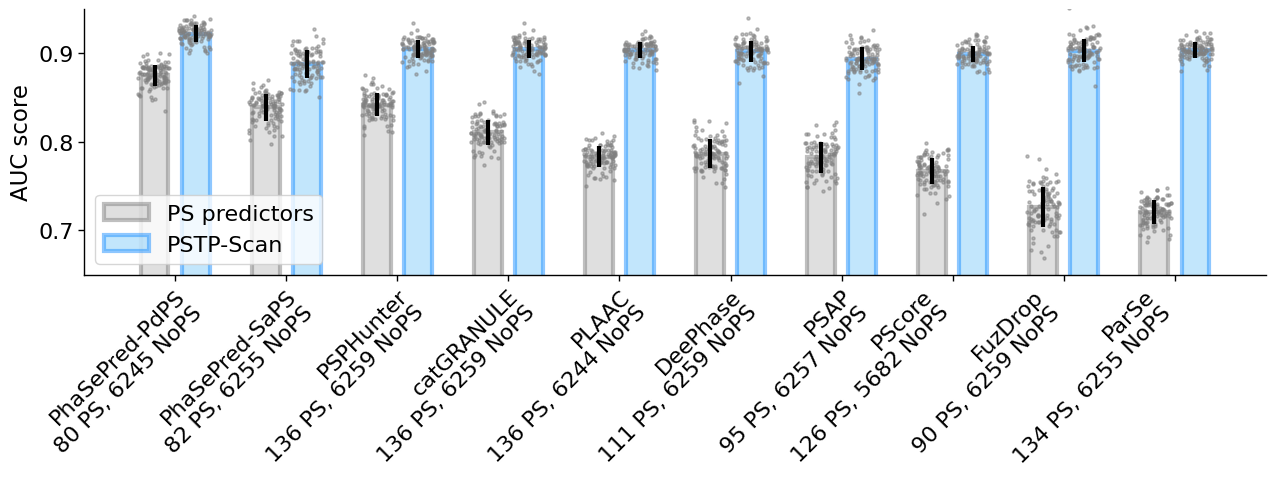

In [ ]:
'''  
Point by point comparison of AUC and AUPR 
'''
labels = ['PhaSePred-PdPS','PhaSePred-SaPS',
          'PSPHunter','catGRANULE','PLAAC',
         'DeePhase','PSAP','PScore',
           'FuzDrop','ParSe'
          ]
rel_pth = 'data_processed/results/independent_test_performances/'
## 

labels2discription = {
    'catGRANULE':'catGRANULE\n 136 PS, 6259 NoPS',
    'PSPHunter':'PSPHunter\n 136 PS, 6259 NoPS',
    'PhaSePred-SaPS':'PhaSePred-SaPS\n 82 PS, 6255 NoPS',
    'PhaSePred-PdPS':'PhaSePred-PdPS\n 80 PS, 6245 NoPS',
    'FuzDrop':'FuzDrop\n 90 PS, 6259 NoPS',
    'DeePhase':'DeePhase\n 111 PS, 6259 NoPS',
    'PScore':'PScore\n 126 PS, 5682 NoPS',
    'PSAP':'PSAP\n 95 PS, 6257 NoPS',
    'PLAAC':'PLAAC\n 136 PS, 6244 NoPS',
    'ParSe':'ParSe\n 134 PS, 6255 NoPS',
}
labels2pth = {
    'catGRANULE':rel_pth+'catGRANULE/',
    'PSPHunter':rel_pth+'psphunter/',
    'PhaSePred-SaPS':rel_pth+'phasepred/saps/',
    'PhaSePred-PdPS':rel_pth+'phasepred/pdps/',
    'FuzDrop':rel_pth+'fuzdrop/',
    'DeePhase':rel_pth+'deephase/',
    'PScore':rel_pth+'pscore/',
    'PSAP':rel_pth+'psap/',
    'PLAAC':rel_pth+'PLAAC/',
    'ParSe':rel_pth+'ParSe/',
}
metric_auc_lsts = []
metric_correpsonding_pstp_auc_lsts = []
metric_aupr_lsts = []
metric_correpsonding_pstp_aupr_lsts = []
for l in labels:
    pth = labels2pth[l]
    metric_auc_lsts.append(np.load(pth+'auc_lst.npy'))
    metric_aupr_lsts.append(np.load(pth+'aupr_lst.npy'))
    metric_correpsonding_pstp_auc_lsts.append(np.load(pth+'pstp_auc_lst.npy'))
    metric_correpsonding_pstp_aupr_lsts.append(np.load(pth+'pstp_aupr_lst.npy'))
metric_auc_avgs = [np.average(x) for x in metric_auc_lsts]
metric_aupr_avgs = [np.average(x) for x in metric_aupr_lsts]
metric_correpsonding_pstp_auc_avgs = [np.average(x) for x in 
                                      metric_correpsonding_pstp_auc_lsts]
metric_correpsonding_pstp_aupr_avgs = [np.average(x) for x in 
                                       metric_correpsonding_pstp_aupr_lsts]
metric_auc_stds = [np.std(x) for x in metric_auc_lsts]
metric_aupr_stds = [np.std(x) for x in metric_aupr_lsts]
metric_correpsonding_pstp_auc_stds = [np.std(x) for x in 
                                      metric_correpsonding_pstp_auc_lsts]
metric_correpsonding_pstp_aupr_stds = [np.std(x) for x in 
                                       metric_correpsonding_pstp_aupr_lsts]
###############################

bar_width = 0.25
index = np.arange(len(labels))
import matplotlib.pyplot as plt
np.random.seed(1016)
fig, ax = plt.subplots(figsize=(13,5))

error_config = {'elinewidth': 3, 
                'ecolor': 'black', 'capsize': 0}

bar0 = ax.bar(index-bar_width/2- 0.06, metric_auc_avgs, bar_width, 
              label='PS predictors', color='silver',alpha=0.5, 
              error_kw=error_config,
              yerr=metric_auc_stds,capsize=0,)
bar1 = ax.bar(index+bar_width/2+0.06, metric_correpsonding_pstp_auc_avgs, 
              bar_width, label='PSTP-Scan',  
              error_kw=error_config,
              color='lightskyblue',alpha=0.5,yerr=metric_correpsonding_pstp_auc_stds,
              capsize=0, )


for i, data_points in enumerate(
    metric_auc_lsts):
    x_offset = np.random.uniform(-0.15, 0.15, size=len(data_points))
    
    ax.scatter([index[i]] * len(data_points)+x_offset-bar_width/2- 0.06, 
               data_points, color='gray', zorder=1, alpha=0.5, 
               s=5,edgecolor='gray')
for i, data_points in enumerate(
    metric_correpsonding_pstp_auc_lsts):
    x_offset = np.random.uniform(-0.15, 0.15, size=len(data_points))
    
    ax.scatter([index[i]] * len(data_points)+x_offset+bar_width/2+0.06, 
               data_points, color='gray', zorder=1, alpha=0.5, 
               s=5,edgecolor='gray')
     

for b in bar0:
    b.set_edgecolor('grey')   
    b.set_linewidth(3)  
for b in bar1:
    b.set_edgecolor('dodgerblue')   
    b.set_linewidth(3)  
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.spines['bottom'].set_linewidth(1)
ax.spines['left'].set_linewidth(1)
ax.tick_params(axis='both', which='major', width=1,length=4,labelsize=16)
ax.set_ylabel('AUC score',fontsize=16.5)
# # ax.set_title('Comparison of Paired Data')
ls = [labels2discription[l] for l in labels]
ax.set_xticklabels(ls,rotation=45,ha='right',rotation_mode='anchor',fontsize=16)
ax.set_xticks(index)
ax.legend(fontsize=16)
ax.set_ylim(0.65,0.95)
# legend = ax.legend(loc='upper center', bbox_to_anchor=(0.73,1.10),ncol=2 )
# title = legend.get_title()

# title.set_fontsize(12)   
# title.set_fontweight('medium')



plt.tight_layout()
plt.show()
plt.close()

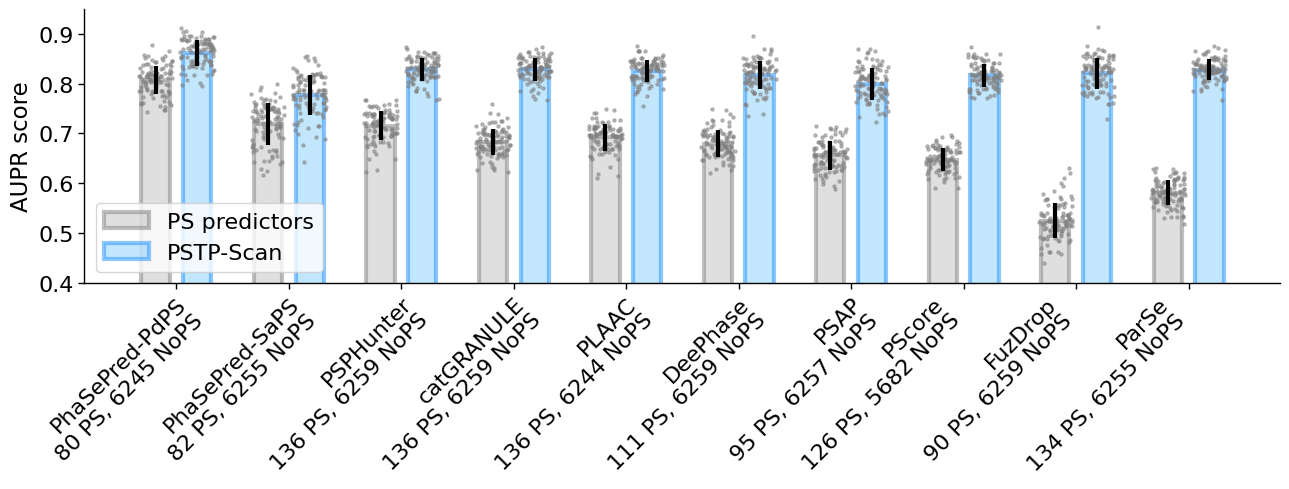

In [ ]:

bar_width = 0.25
index = np.arange(len(labels))
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(13,5))

error_config = {'elinewidth': 3, 
                'ecolor': 'black', 'capsize': 0}

bar0 = ax.bar(index-bar_width/2- 0.06, metric_aupr_avgs, bar_width, 
              label='PS predictors', color='silver',alpha=0.5, 
              error_kw=error_config,
              yerr=metric_aupr_stds,capsize=0,)
bar1 = ax.bar(index+bar_width/2+0.06, metric_correpsonding_pstp_aupr_avgs, 
              bar_width, label='PSTP-Scan',  
              error_kw=error_config,
              color='lightskyblue',alpha=0.5,yerr=metric_correpsonding_pstp_aupr_stds,
              capsize=0, )


for i, data_points in enumerate(
    metric_aupr_lsts):
    x_offset = np.random.uniform(-0.15, 0.15, size=len(data_points))
    
    ax.scatter([index[i]] * len(data_points)+x_offset-bar_width/2- 0.06, 
               data_points, color='gray', zorder=1, alpha=0.5, 
               s=5,edgecolor='gray')
for i, data_points in enumerate(
    metric_correpsonding_pstp_aupr_lsts):
    x_offset = np.random.uniform(-0.15, 0.15, size=len(data_points))
    
    ax.scatter([index[i]] * len(data_points)+x_offset+bar_width/2+0.06, 
               data_points, color='gray', zorder=1, alpha=0.5, 
               s=5,edgecolor='gray')
     

for b in bar0:
    b.set_edgecolor('grey')  
    b.set_linewidth(3)  
for b in bar1:
    b.set_edgecolor('dodgerblue')   
    b.set_linewidth(3)  
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.spines['bottom'].set_linewidth(1)
ax.spines['left'].set_linewidth(1)
ax.tick_params(axis='both', which='major', width=1,length=4,labelsize=16)
ax.set_ylabel('AUPR score',fontsize=16.5)
# # ax.set_title('Comparison of Paired Data')
ls = [labels2discription[l] for l in labels]
ax.set_xticklabels(ls,rotation=45,ha='right',rotation_mode='anchor',fontsize=16)
ax.set_xticks(index)
ax.legend(fontsize=16)
ax.set_ylim(0.4,0.95)
# legend = ax.legend(loc='upper center', bbox_to_anchor=(0.73,1.10),ncol=2 )
# title = legend.get_title()

# title.set_fontsize(12)   
# title.set_fontweight('medium')



plt.tight_layout()
plt.show()
plt.close()

average AUC/AUPR: 0.9041990160034601 0.8258328912432745
average AUC/AUPR: 0.8973959234429063 0.809914803083106
average AUC/AUPR: 0.9039427443771626 0.8235714561427809
0.8754881176746067 0.7606271189339298


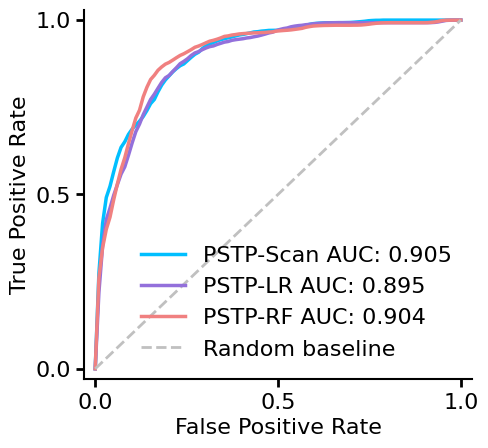

In [ ]:
'''  
ROC AUC GRAPH
'''
from sklearn.metrics import roc_curve,roc_auc_score

def merge_results_for_auc(paired_labels_predicted,mean_auc_evaluation_metric='A'):
    '''
    
    paired_labels_predicted = [[[l1,l2,...],[p1,p2,p3,...]],
                                [[12,l2,....,],[p1,p2,p3,...]],
                                [[],[]],[[],[]]]
    '''
    experiments_preds = [predicted for _,predicted in paired_labels_predicted]
    experiments_labels = [labels for labels,_ in paired_labels_predicted]
    mean_fpr = np.linspace(0, 1, 100)
    tprs = []
    for i, (y_true, y_pred) in enumerate(zip(experiments_labels, experiments_preds)):
        fpr, tpr, _ = roc_curve(y_true, y_pred)
        auc_ = auc(fpr, tpr)
        tpr_interp = np.interp(mean_fpr, fpr, tpr)
        tpr_interp[0] = 0.0
        tprs.append(tpr_interp)

    mean_tpr = np.mean(tprs, axis=0)
    mean_tpr[-1] = 1.0
    std_tpr = np.std(tprs, axis=0)

    tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
    tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
    # roc_auc = auc_total/len(experiments_labels)
    if mean_auc_evaluation_metric=='A':
        fpr, tpr, _ = roc_curve(experiments_labels[0],np.average(experiments_preds,axis=0))
        mean_fpr,mean_tpr = fpr,tpr 
        tprs_lower,tprs_upper = tpr,tpr
        roc_auc = roc_auc_score(experiments_labels[0],np.average(experiments_preds,axis=0))
    else:
        
        roc_auc = np.average([roc_auc_score(label,pred) for label,pred in zip(experiments_labels,experiments_preds)])
    return fpr,tpr,roc_auc,mean_fpr,mean_tpr,tprs_lower,tprs_upper


def merge_results_aupr(paired_labels_predicted):
    '''
    paired_labels_predicted = [[[l1,l2,...],[p1,p2,p3,...]],
                                [[12,l2,....,],[p1,p2,p3,...]],
                                [[],[]],[[],[]]]
    '''
    experiments_preds = [predicted for _,predicted in paired_labels_predicted]
    experiments_labels = [labels for labels,_ in paired_labels_predicted]
    
    precisions,recalls,auprs = [],[],[]
    auc_total = 0
    interp_range = np.linspace(0, 1, num=101)
    for i, (y_true, y_pred) in enumerate(zip(experiments_labels, experiments_preds)):
        precision,recall,_ = precision_recall_curve(y_true, y_pred)
        interp_precision = np.interp(interp_range, recall[::-1], precision[::-1])
        interp_recall = interp_range
        aupr = auc(interp_recall, interp_precision)
        precisions.append(interp_precision)
        recalls.append(interp_recall)
        auprs.append(aupr)

    
    precision_mean = np.mean(precisions, axis=0)
    recall_mean = np.mean(recalls, axis=0)
    aupr_mean = np.mean(auprs)
    aupr_std = np.std(auprs)
    
    return auprs,recalls,precision_mean,recall_mean,aupr_mean,aupr_std,



'''  
pstp_scan/RF/LR results
'''
np.random.seed(1016)
results_idx = np.load(f'{pstp_scan_results}/val_idx_lst_lst.npy')
results_py = np.load(f'{pstp_scan_results}/val_py_lst_lst.npy')
results_ty = np.load(f'{pstp_scan_results}/val_ty_lst_lst.npy')
original_idx = list(hps167_samples_idx) + list(nonhps5754_samples_idx)
uids_ = list(hps167_samples_uids) + list(hnops_samples_uids)
avg_pylst = []
pstp_scan_pairs = []
scan_aucs,scan_auprs = [],[]
for idxlst,pylst,tylst in zip(results_idx,results_py,results_ty):
    pylst = np.array(pylst)[reverse_index_map(original_idx,idxlst)]
    tylst = np.array(tylst)[reverse_index_map(original_idx,idxlst)]
    avg_pylst.append(pylst)
    pstp_scan_pairs.append([list(tylst),list(pylst)])
avg_pylst = np.average(avg_pylst,axis=0)
l1,l2 = balanced_auc_aupr_v3(tylst,avg_pylst)
scan_avg_py_lst = avg_pylst
scan_aucs+=l1
scan_auprs+=l2

    
results_idx = np.load('data_processed/results/independent_pstp/LR/val_idx_lst_lst.npy')
results_py = np.load('data_processed/results/independent_pstp/LR/val_py_lst_lst.npy')
results_ty = np.load('data_processed/results/independent_pstp/LR/val_ty_lst_lst.npy')
original_idx = list(hps167_samples_idx) + list(nonhps5754_samples_idx)
uids_ = list(hps167_samples_uids) + list(hnops_samples_uids)
avg_pylst = []
pstp_lr_pairs = []
lr_aucs,lr_auprs = [],[]
for idxlst,pylst,tylst in zip(results_idx,results_py,results_ty):
    pylst = np.array(pylst)[reverse_index_map(original_idx,idxlst)]
    tylst = np.array(tylst)[reverse_index_map(original_idx,idxlst)]
    avg_pylst.append(pylst)
    pstp_lr_pairs.append([list(tylst),list(pylst)])
avg_pylst = np.average(avg_pylst,axis=0)
l1,l2 = balanced_auc_aupr_v3(tylst,avg_pylst)
lr_aucs+=l1
lr_auprs+=l2
lr_avg_py_lst = avg_pylst

  
results_idx = np.load('data_processed/results/independent_pstp/RF/val_idx_lst_lst.npy')
results_py = np.load('data_processed/results/independent_pstp/RF/val_py_lst_lst.npy')
results_ty = np.load('data_processed/results/independent_pstp/RF/val_ty_lst_lst.npy')
original_idx = list(hps167_samples_idx) + list(nonhps5754_samples_idx)
uids_ = list(hps167_samples_uids) + list(hnops_samples_uids)
avg_pylst = []
pstp_rf_pairs = []
rf_aucs,rf_auprs = [],[]
for idxlst,pylst,tylst in zip(results_idx,results_py,results_ty):
    pylst = np.array(pylst)[reverse_index_map(original_idx,idxlst)]
    tylst = np.array(tylst)[reverse_index_map(original_idx,idxlst)]
    avg_pylst.append(pylst)
    pstp_rf_pairs.append([list(tylst),list(pylst)])
    
avg_pylst = np.average(avg_pylst,axis=0)
rf_avg_py_lst = avg_pylst
l1,l2 = balanced_auc_aupr_v3(tylst,avg_pylst)
rf_aucs+=l1
rf_auprs+=l2
print(max(rf_auprs),min(rf_auprs))



def get_predicted_pairs(y_true,y_predicted):
    '''
    y_true,y_predicted as input 
    assert negative size >> positive size 
    '''
    y_true = np.array(y_true)
    y_predicted = np.array(y_predicted)
    label_0_indices = np.where(y_true == 0)
    label_1_indices = np.where(y_true == 1)
    py_label0 = np.array(y_predicted)[label_0_indices]
    py_label1 = np.array(y_predicted)[label_1_indices]
    sample_size_ = len(py_label1)*2
    total_pairs = []
    for _ in range(100):
        py_label0_sampled = np.random.choice(py_label0, size=sample_size_, replace=False)
        py_label1_sampled = py_label1
        py_sampled = list(py_label0_sampled)+list(py_label1_sampled)
        ty_sampled = [0]*len(py_label0_sampled)+[1]*len(py_label1_sampled)
        total_pairs.append([ty_sampled,py_sampled])
    return total_pairs

import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(5,4.8))
pstp_scan_pairs = get_predicted_pairs(tylst,scan_avg_py_lst)
pstp_lr_pairs = get_predicted_pairs(tylst,lr_avg_py_lst)
pstp_rf_pairs = get_predicted_pairs(tylst,rf_avg_py_lst)

_,_,mean_auc1,mean_fpr1,mean_tpr1,tprs_lower,tprs_upper = merge_results_for_auc(
    pstp_scan_pairs,mean_auc_evaluation_metric='B')
_,_,mean_auc2,mean_fpr2,mean_tpr2,tprs_lower,tprs_upper = merge_results_for_auc(
    pstp_lr_pairs,mean_auc_evaluation_metric='B')
_,_,mean_auc3,mean_fpr3,mean_tpr3,tprs_lower,tprs_upper = merge_results_for_auc(
    pstp_rf_pairs,mean_auc_evaluation_metric='B')

plt.plot(mean_fpr1, mean_tpr1, color='deepskyblue', lw=2.5, 
         label=f"PSTP-Scan AUC: {mean_auc1:.3f}")

plt.plot(mean_fpr2, mean_tpr2, color='mediumpurple', lw=2.5, 
         label=f"PSTP-LR AUC: {mean_auc2:.3f}")

plt.plot(mean_fpr3, mean_tpr3, color='lightcoral', lw=2.5, 
         label=f"PSTP-RF AUC: {mean_auc3:.3f}")

###############################
plt.plot([0, 1], [0, 1], 'k--',lw=2,color='silver',label='Random baseline')
legend = plt.legend(loc='lower right',frameon=False,fontsize=16)
title = legend.get_title()
title.set_position((-10,0))   
title.set_fontsize(14)   
title.set_fontweight('medium')
ax = plt.gca()
ax.spines["top"].set_linewidth(False)
ax.spines["right"].set_linewidth(False)
ax.spines['bottom'].set_linewidth(1.5)
ax.spines['left'].set_linewidth(1.5)
plt.tick_params(axis='both', which='major', width=2,length=6)

plt.xlim([-0.03, 1.03])
plt.ylim([-0.03, 1.03])
plt.xticks([0,0.5,1],fontsize=16)
plt.yticks([0,0.5,1],fontsize=16)
plt.xlabel('False Positive Rate',fontsize=16)
plt.ylabel('True Positive Rate',fontsize=16)
# plt.tight_layout()
plt.show()


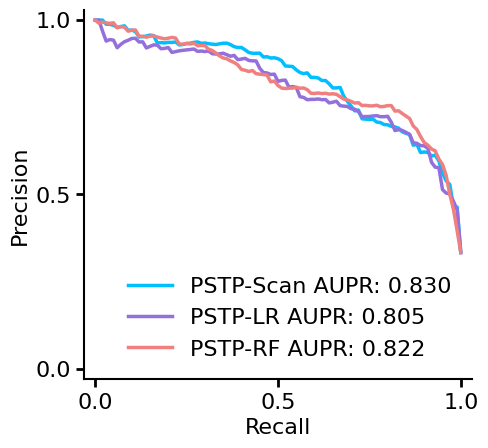

In [ ]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(5,4.8))
_,_,precision_mean1,recall_mean1,aupr_mean1,aupr_std = \
    merge_results_aupr(pstp_scan_pairs,)
_,_,precision_mean2,recall_mean2,aupr_mean2,aupr_std = \
    merge_results_aupr(pstp_lr_pairs,)
_,_,precision_mean3,recall_mean3,aupr_mean3,aupr_std = \
    merge_results_aupr(pstp_rf_pairs,)


plt.plot(recall_mean1, precision_mean1, color='deepskyblue', lw=2.5, 
         label=f"PSTP-Scan AUPR: {aupr_mean1:.3f}")
plt.plot(recall_mean2, precision_mean2, color='mediumpurple', lw=2.5, 
         label=f"PSTP-LR AUPR: {aupr_mean2:.3f}")
plt.plot(recall_mean3, precision_mean3, color='lightcoral', lw=2.5, 
         label=f"PSTP-RF AUPR: {aupr_mean3:.3f}")
################
legend = plt.legend(loc='lower right',frameon=False,fontsize=16)
title = legend.get_title()
title.set_position((-10,0))   
title.set_fontsize(14)   
title.set_fontweight('medium')
ax = plt.gca()
ax.spines["top"].set_linewidth(False)
ax.spines["right"].set_linewidth(False)
ax.spines['bottom'].set_linewidth(1.5)
ax.spines['left'].set_linewidth(1.5)
plt.tick_params(axis='both', which='major', width=2,length=6)
# # plt.plot([0, 1], [0, 1], 'k--',lw=2,color='silver')
plt.xlim([-0.03, 1.03])
plt.ylim([-0.03, 1.03])
plt.xticks([0,0.5,1],fontsize=16)
plt.yticks([0,0.5,1],fontsize=16)
plt.xlabel('Recall',fontsize=16)
plt.ylabel('Precision',fontsize=16)
plt.show()

p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

PSTP-Scan
 (PS) vs. PSTP-Scan
 (NoPS): t-test independent samples, P_val:2.260e-99 t=2.154e+01
PSTP-LR
 (PS) vs. PSTP-LR
 (NoPS): t-test independent samples, P_val:2.795e-96 t=2.118e+01
PSTP-RF
 (PS) vs. PSTP-RF
 (NoPS): t-test independent samples, P_val:1.192e-128 t=2.469e+01


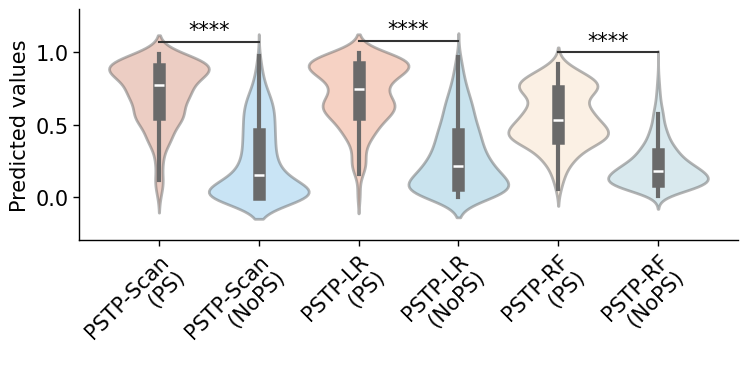

In [ ]:
'''
graph score distribution of different PSTP models
'''
import seaborn as sns 
from statannotations.Annotator import Annotator
def classify_positive_negative(score_lst,bool_lst):
    pos_lst,neg_lst = [],[]
    for item,l in zip(score_lst,bool_lst):
        if l == 0:
            neg_lst.append(item)
        else:
            pos_lst.append(item) 
    return pos_lst,neg_lst 

scan_positive,scan_negative = classify_positive_negative(
    scan_avg_py_lst,tylst)
lr_positive,lr_negative = classify_positive_negative(
    lr_avg_py_lst,tylst
)
rf_positive,rf_negative = classify_positive_negative(
    rf_avg_py_lst,tylst
)

def graph_phasepred_comparison(dat_lst_lst,names,pairs=None,
                               ylabel='AUC',savepth=None,
                               title='',ylim=None,):
    '''  
    dat_lst_lst contains list of score list
    '''
    groups,values = [],[]
    for lst,name in zip(dat_lst_lst,names):
        groups += [name]*len(lst)
        values += list(lst)
    
    data = pd.DataFrame({
        'Group': groups,
        'Value': values,
        
    })
    fig, ax = plt.subplots(figsize=(8.5,3))
    sns.violinplot(x='Group', y='Value', data=data,alpha=0.5,
                   color='gainsboro',width=1,
                   bw=0.3,linewidth=2,palette=[
                       'darksalmon','lightskyblue',
                       'lightsalmon','skyblue',
                       'bisque','lightblue'],
                   zorder=0)    
    
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    ax.spines['bottom'].set_linewidth(1)
    ax.spines['left'].set_linewidth(1)
    ax.tick_params(axis='both', which='major', width=1,length=4,labelsize=15)
    ax.set_ylabel(ylabel,fontsize=15)
    ax.set_xticklabels(names,rotation=45,ha='right',rotation_mode='anchor')
    ax.set_xlabel('')
    ax.set_title(title)
    if pairs:
        anno = Annotator(ax,pairs,x='Group', y='Value', data=data,
                         )
        anno.configure(test='t-test_ind',fontsize=15,line_height=0,) 
        anno.apply_and_annotate()
    if ylim:
        ax.set_ylim(ylim)
    
    if savepth:
        plt.savefig(savepth)
    plt.show()
    
score_lst = [
    scan_positive,scan_negative,
            lr_positive,lr_negative,
            rf_positive,rf_negative]
names_ = ['PSTP-Scan\n (PS)','PSTP-Scan\n (NoPS)',
          'PSTP-LR\n (PS)','PSTP-LR\n (NoPS)',
          'PSTP-RF\n (PS)','PSTP-RF\n (NoPS)',
          ]
box_pairs_ = [('PSTP-Scan\n (PS)','PSTP-Scan\n (NoPS)',),
                ('PSTP-LR\n (PS)','PSTP-LR\n (NoPS)',),
                ('PSTP-RF\n (PS)','PSTP-RF\n (NoPS)',),]
graph_phasepred_comparison(score_lst,ylim=(-0.3,1.3),
     names=names_,ylabel='Predicted values',pairs=box_pairs_,
     )

In [15]:
results_idx = np.load(
    'data_processed/results/independent_pstp_scan_fixed/kernel33/val_idx_lst_lst.npy')
results_py = np.load(
    'data_processed/results/independent_pstp_scan_fixed/kernel33/val_py_lst_lst.npy')
results_ty = np.load(
    'data_processed/results/independent_pstp_scan_fixed/kernel33/val_ty_lst_lst.npy')
original_idx = list(hps167_samples_idx) + list(nonhps5754_samples_idx)
avg_pylst = []
pstp_scan_pairs = []
scan_aucs,scan_auprs = [],[]
for idxlst,pylst,tylst in zip(results_idx,results_py,results_ty):
    pylst = np.array(pylst)[reverse_index_map(original_idx,idxlst)]
    tylst = np.array(tylst)[reverse_index_map(original_idx,idxlst)]
    avg_pylst.append(pylst)
    pstp_scan_pairs.append([list(tylst),list(pylst)])
avg_pylst = np.average(avg_pylst,axis=0)
l1,l2 = balanced_auc_aupr_v3(tylst,avg_pylst)
scan33_avg_py_lst = avg_pylst


results_idx = np.load(
    'data_processed/results/independent_pstp_scan_fixed/kernel65/val_idx_lst_lst.npy')
results_py = np.load(
    'data_processed/results/independent_pstp_scan_fixed/kernel65/val_py_lst_lst.npy')
results_ty = np.load(
    'data_processed/results/independent_pstp_scan_fixed/kernel65/val_ty_lst_lst.npy')
original_idx = list(hps167_samples_idx) + list(nonhps5754_samples_idx)
avg_pylst = []
pstp_scan_pairs = []
scan_aucs,scan_auprs = [],[]
for idxlst,pylst,tylst in zip(results_idx,results_py,results_ty):
    pylst = np.array(pylst)[reverse_index_map(original_idx,idxlst)]
    tylst = np.array(tylst)[reverse_index_map(original_idx,idxlst)]
    avg_pylst.append(pylst)
    pstp_scan_pairs.append([list(tylst),list(pylst)])
avg_pylst = np.average(avg_pylst,axis=0)
l1,l2 = balanced_auc_aupr_v3(tylst,avg_pylst)
scan65_avg_py_lst = avg_pylst

results_idx = np.load(
    'data_processed/results/independent_pstp_scan_fixed/kernel129/val_idx_lst_lst.npy')
results_py = np.load(
    'data_processed/results/independent_pstp_scan_fixed/kernel129/val_py_lst_lst.npy')
results_ty = np.load(
    'data_processed/results/independent_pstp_scan_fixed/kernel129/val_ty_lst_lst.npy')
original_idx = list(hps167_samples_idx) + list(nonhps5754_samples_idx)
avg_pylst = []
pstp_scan_pairs = []
scan_aucs,scan_auprs = [],[]
for idxlst,pylst,tylst in zip(results_idx,results_py,results_ty):
    pylst = np.array(pylst)[reverse_index_map(original_idx,idxlst)]
    tylst = np.array(tylst)[reverse_index_map(original_idx,idxlst)]
    avg_pylst.append(pylst)
    pstp_scan_pairs.append([list(tylst),list(pylst)])
avg_pylst = np.average(avg_pylst,axis=0)
l1,l2 = balanced_auc_aupr_v3(tylst,avg_pylst)
scan129_avg_py_lst = avg_pylst


results_idx = np.load(
    'data_processed/results/independent_pstp_scan_fixed/kernel257/val_idx_lst_lst.npy')
results_py = np.load(
    'data_processed/results/independent_pstp_scan_fixed/kernel257/val_py_lst_lst.npy')
results_ty = np.load(
    'data_processed/results/independent_pstp_scan_fixed/kernel257/val_ty_lst_lst.npy')
original_idx = list(hps167_samples_idx) + list(nonhps5754_samples_idx)
avg_pylst = []
pstp_scan_pairs = []
scan_aucs,scan_auprs = [],[]
for idxlst,pylst,tylst in zip(results_idx,results_py,results_ty):
    pylst = np.array(pylst)[reverse_index_map(original_idx,idxlst)]
    tylst = np.array(tylst)[reverse_index_map(original_idx,idxlst)]
    avg_pylst.append(pylst)
    pstp_scan_pairs.append([list(tylst),list(pylst)])
avg_pylst = np.average(avg_pylst,axis=0)
l1,l2 = balanced_auc_aupr_v3(tylst,avg_pylst)
scan257_avg_py_lst = avg_pylst

results_idx = np.load(
    'data_processed/results/independent_pstp_scan_fixed/kernel513/val_idx_lst_lst.npy')
results_py = np.load(
    'data_processed/results/independent_pstp_scan_fixed/kernel513/val_py_lst_lst.npy')
results_ty = np.load(
    'data_processed/results/independent_pstp_scan_fixed/kernel513/val_ty_lst_lst.npy')
original_idx = list(hps167_samples_idx) + list(nonhps5754_samples_idx)
avg_pylst = []
pstp_scan_pairs = []
scan_aucs,scan_auprs = [],[]
for idxlst,pylst,tylst in zip(results_idx,results_py,results_ty):
    pylst = np.array(pylst)[reverse_index_map(original_idx,idxlst)]
    tylst = np.array(tylst)[reverse_index_map(original_idx,idxlst)]
    avg_pylst.append(pylst)
    pstp_scan_pairs.append([list(tylst),list(pylst)])
avg_pylst = np.average(avg_pylst,axis=0)
l1,l2 = balanced_auc_aupr_v3(tylst,avg_pylst)
scan513_avg_py_lst = avg_pylst

results_idx = np.load(
    'data_processed/results/independent_pstp_scan_kernel/val_idx_lst_lst.npy')
results_py = np.load(
    'data_processed/results/independent_pstp_scan_kernel/val_py_lst_lst.npy')
results_ty = np.load(
    'data_processed/results/independent_pstp_scan_kernel/val_ty_lst_lst.npy')
original_idx = list(hps167_samples_idx) + list(nonhps5754_samples_idx)
avg_pylst = []
pstp_scan_pairs = []
scan_aucs,scan_auprs = [],[]
for idxlst,pylst,tylst in zip(results_idx,results_py,results_ty):
    pylst = np.array(pylst)[reverse_index_map(original_idx,idxlst)]
    tylst = np.array(tylst)[reverse_index_map(original_idx,idxlst)]
    avg_pylst.append(pylst)
    pstp_scan_pairs.append([list(tylst),list(pylst)])
avg_pylst = np.average(avg_pylst,axis=0)
l1,l2 = balanced_auc_aupr_v3(tylst,avg_pylst)
kernel_avg_py_lst = avg_pylst

average AUC/AUPR: 0.8972156141868516 0.821244902990249
average AUC/AUPR: 0.900532547577855 0.8199154487755655
average AUC/AUPR: 0.9045566608996539 0.8240299573599966
average AUC/AUPR: 0.9041276492214533 0.8225299105746072
average AUC/AUPR: 0.8962551362456744 0.8070907664109852
average AUC/AUPR: 0.870955071366782 0.780736163704674


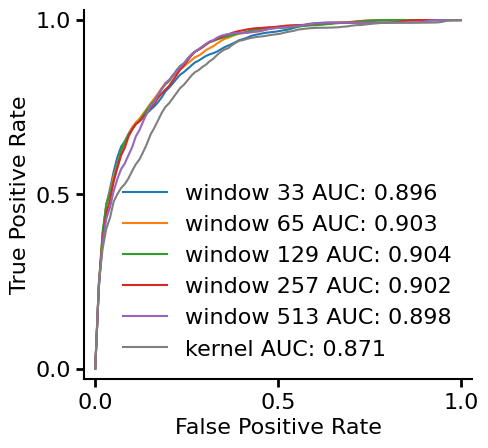

In [ ]:
fig, ax = plt.subplots(figsize=(5,4.8))
random.seed(1016)
pstp_scan33_pairs = get_predicted_pairs(tylst,scan33_avg_py_lst)
pstp_scan65_pairs = get_predicted_pairs(tylst,scan65_avg_py_lst)
pstp_scan129_pairs = get_predicted_pairs(tylst,scan129_avg_py_lst)
pstp_scan257_pairs = get_predicted_pairs(tylst,scan257_avg_py_lst)
pstp_scan513_pairs = get_predicted_pairs(tylst,scan513_avg_py_lst)
pstp_kernel_pairs = get_predicted_pairs(tylst,kernel_avg_py_lst)

_,_,mean_auc1,mean_fpr1,mean_tpr1,_,_ = merge_results_for_auc(
    pstp_scan33_pairs,mean_auc_evaluation_metric='B')
_,_,mean_auc2,mean_fpr2,mean_tpr2,_,_ = merge_results_for_auc(
    pstp_scan65_pairs,mean_auc_evaluation_metric='B')
_,_,mean_auc3,mean_fpr3,mean_tpr3,_,_ = merge_results_for_auc(
    pstp_scan129_pairs,mean_auc_evaluation_metric='B')
_,_,mean_auc4,mean_fpr4,mean_tpr4,_,_ = merge_results_for_auc(
    pstp_scan257_pairs,mean_auc_evaluation_metric='B')
_,_,mean_auc5,mean_fpr5,mean_tpr5,_,_ = merge_results_for_auc(
    pstp_scan513_pairs,mean_auc_evaluation_metric='B')
_,_,mean_auc6,mean_fpr6,mean_tpr6,_,_= merge_results_for_auc(
    pstp_kernel_pairs,mean_auc_evaluation_metric='B')

plt.plot(mean_fpr1, mean_tpr1, color='tab:blue', lw=1.5, 
         label=f"window 33 AUC: {mean_auc1:.3f}")
plt.plot(mean_fpr2, mean_tpr2, color='tab:orange', lw=1.5, 
         label=f"window 65 AUC: {mean_auc2:.3f}")
plt.plot(mean_fpr3, mean_tpr3, color='tab:green', lw=1.5, 
         label=f"window 129 AUC: {mean_auc3:.3f}")
plt.plot(mean_fpr4, mean_tpr4, color='tab:red', lw=1.5, 
         label=f"window 257 AUC: {mean_auc4:.3f}")
plt.plot(mean_fpr5, mean_tpr5, color='tab:purple', lw=1.5, 
         label=f"window 513 AUC: {mean_auc5:.3f}")
plt.plot(mean_fpr6, mean_tpr6, color='tab:gray', lw=1.5, 
         label=f"kernel AUC: {mean_auc6:.3f}")

###############################
legend = plt.legend(loc='lower right',frameon=False,fontsize=16)
title = legend.get_title()
title.set_position((-10,0))   
title.set_fontsize(14)   
title.set_fontweight('medium')
ax = plt.gca()
ax.spines["top"].set_linewidth(False)
ax.spines["right"].set_linewidth(False)
ax.spines['bottom'].set_linewidth(1.5)
ax.spines['left'].set_linewidth(1.5)
plt.tick_params(axis='both', which='major', width=2,length=6)
# plt.plot([0, 1], [0, 1], 'k--',lw=2,color='silver')
plt.xlim([-0.03, 1.03])
plt.ylim([-0.03, 1.03])
plt.xticks([0,0.5,1],fontsize=16)
plt.yticks([0,0.5,1],fontsize=16)
plt.xlabel('False Positive Rate',fontsize=16)
plt.ylabel('True Positive Rate',fontsize=16)
plt.show()

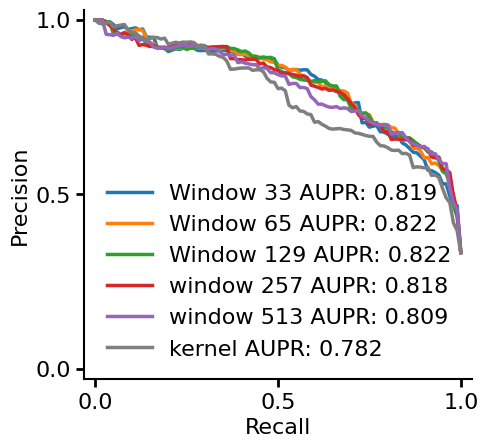

In [ ]:
fig, ax = plt.subplots(figsize=(5,4.8))
random.seed(1016)

_,_,mean_auc1,mean_fpr1,mean_tpr1,_,_ = merge_results_for_auc(
    pstp_scan33_pairs,mean_auc_evaluation_metric='B')
_,_,mean_auc2,mean_fpr2,mean_tpr2,_,_ = merge_results_for_auc(
    pstp_scan65_pairs,mean_auc_evaluation_metric='B')
_,_,mean_auc3,mean_fpr3,mean_tpr3,_,_ = merge_results_for_auc(
    pstp_scan129_pairs,mean_auc_evaluation_metric='B')
_,_,mean_auc4,mean_fpr4,mean_tpr4,_,_ = merge_results_for_auc(
    pstp_scan257_pairs,mean_auc_evaluation_metric='B')
_,_,mean_auc5,mean_fpr5,mean_tpr5,_,_ = merge_results_for_auc(
    pstp_scan513_pairs,mean_auc_evaluation_metric='B')
_,_,mean_auc6,mean_fpr6,mean_tpr6,_,_= merge_results_for_auc(
    pstp_kernel_pairs,mean_auc_evaluation_metric='B')

_,_,precision_mean1,recall_mean1,aupr_mean1,aupr_std = \
    merge_results_aupr(pstp_scan33_pairs,)
_,_,precision_mean2,recall_mean2,aupr_mean2,aupr_std = \
    merge_results_aupr(pstp_scan65_pairs,)
_,_,precision_mean3,recall_mean3,aupr_mean3,aupr_std = \
    merge_results_aupr(pstp_scan129_pairs,)
_,_,precision_mean4,recall_mean4,aupr_mean4,aupr_std = \
    merge_results_aupr(pstp_scan257_pairs,)
_,_,precision_mean5,recall_mean5,aupr_mean5,aupr_std = \
    merge_results_aupr(pstp_scan513_pairs,)
_,_,precision_mean6,recall_mean6,aupr_mean6,aupr_std = \
    merge_results_aupr(pstp_kernel_pairs,)


plt.plot(recall_mean1, precision_mean1, color='tab:blue', lw=2.5, 
         label=f"Window 33 AUPR: {aupr_mean1:.3f}")
plt.plot(recall_mean2, precision_mean2, color='tab:orange', lw=2.5, 
         label=f"Window 65 AUPR: {aupr_mean2:.3f}")
plt.plot(recall_mean3, precision_mean3, color='tab:green', lw=2.5, 
         label=f"Window 129 AUPR: {aupr_mean3:.3f}")
plt.plot(recall_mean4, precision_mean4, color='tab:red', lw=2.5, 
         label=f"window 257 AUPR: {aupr_mean4:.3f}")
plt.plot(recall_mean5, precision_mean5, color='tab:purple', lw=2.5, 
         label=f"window 513 AUPR: {aupr_mean5:.3f}")
plt.plot(recall_mean6, precision_mean6, color='tab:gray', lw=2.5, 
         label=f"kernel AUPR: {aupr_mean6:.3f}")
################
legend = plt.legend(loc='lower right',frameon=False,fontsize=16)
title = legend.get_title()
title.set_position((-10,0))   
title.set_fontsize(14)   
title.set_fontweight('medium')
ax = plt.gca()
ax.spines["top"].set_linewidth(False)
ax.spines["right"].set_linewidth(False)
ax.spines['bottom'].set_linewidth(1.5)
ax.spines['left'].set_linewidth(1.5)
plt.tick_params(axis='both', which='major', width=2,length=6)
# # plt.plot([0, 1], [0, 1], 'k--',lw=2,color='silver')
plt.xlim([-0.03, 1.03])
plt.ylim([-0.03, 1.03])
plt.xticks([0,0.5,1],fontsize=16)
plt.yticks([0,0.5,1],fontsize=16)
plt.xlabel('Recall',fontsize=16)
plt.ylabel('Precision',fontsize=16)
# plt.tight_layout()
plt.show()
